# Sprawozdanie 2
## Jakub Ciągło (275986), Mateusz Ćwiek (276011)

___
# Importy

In [125]:
import scipy.stats as stats
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
import math
import matplotlib.pyplot as plt

___
# Część 1
## Zadanie 1
**Oszacowanie rozkładu opinii o szkoleniu – przedziały ufności dla wektora prawdopodobieństw** 

W zadaniu analizujemy odpowiedzi 200 pracowników, którzy oceniali szkolenie „Efektywna komunikacja w zespole”. Opinie zostały pogrupowane w pięć kategorii:  

Na podstawie uzyskanych liczebności wyznaczamy przedziały ufności dla częstości odpowiedzi w każdej kategorii, traktując te częstości jako estymacje elementów wektora prawdopodobieństw dyskretnego rozkładu opinii.  

Uwzględniamy dwa podejścia:  
- Dokładne przedziały Cloppera-Pearsona oparte na rozkładzie beta,  
- Przybliżone przedziały Wilsona (asymptotyczne).  

Ze względu na pięć kategorii, poziom ufności dla każdej z nich został skorygowany metodą Bonferroniego (czyli poziom istotności $ \alpha = 0.05 $ podzielono przez $5$).  

Przedziały zostały wyznaczone niezależnie dla każdej kategorii, zakładając próbę o stałej liczebności $ n = 200 $.

In [126]:
def clopper_pearson_ci(successes, trials, alpha):
    lower = stats.beta.ppf(alpha / 2, successes, trials - successes + 1)
    upper = stats.beta.ppf(1 - alpha / 2, successes + 1, trials - successes)
    return lower, upper

def wyznacz_przedzialy_ufnosci(liczebnosci, alpha=0.05):
    n = np.sum(liczebnosci)
    kategorie = len(liczebnosci)
    
    adjusted_alpha = alpha / kategorie

    przedzialy = []

    for i, sukcesy in enumerate(liczebnosci):
        cp_lower, cp_upper = clopper_pearson_ci(sukcesy, n, adjusted_alpha)

        wilson_lower, wilson_upper = proportion_confint(sukcesy, n, alpha=adjusted_alpha, method='wilson')

        przedzialy.append({
            'kategoria': i + 1,
            'dokladny': (cp_lower, cp_upper),
            'asymptotyczny': (wilson_lower, wilson_upper)
        })

    return przedzialy

liczebnosci = np.array([14, 17, 40, 100, 29])
przedzialy = wyznacz_przedzialy_ufnosci(liczebnosci, alpha=0.05)

for przedzial in przedzialy:
    print(f"Kategoria {przedzial['kategoria']}")
    print(f"  Metoda Clopper-Pearson: ({przedzial['dokladny'][0]:.3f}, {przedzial['dokladny'][1]:.3f})")
    print(f"  Metoda Wilson:          ({przedzial['asymptotyczny'][0]:.3f}, {przedzial['asymptotyczny'][1]:.3f})\n")


Kategoria 1
  Metoda Clopper-Pearson: (0.032, 0.130)
  Metoda Wilson:          (0.036, 0.132)

Kategoria 2
  Metoda Clopper-Pearson: (0.042, 0.149)
  Metoda Wilson:          (0.047, 0.150)

Kategoria 3
  Metoda Clopper-Pearson: (0.133, 0.282)
  Metoda Wilson:          (0.137, 0.282)

Kategoria 4
  Metoda Clopper-Pearson: (0.407, 0.593)
  Metoda Wilson:          (0.410, 0.590)

Kategoria 5
  Metoda Clopper-Pearson: (0.087, 0.220)
  Metoda Wilson:          (0.092, 0.221)



___
## Zadanie 2
**Poziomy krytyczne w testach dopasowania rozkładu – testy chi-kwadrat**

Celem zadania było stworzenie funkcji obliczającej poziomy krytyczne (p-value) w dwóch klasycznych testach dopasowania rozkładu wielomianowego:

- Test chi-kwadrat Pearsona,  
- Test chi-kwadrat największej wiarygodności.

Weryfikujemy hipotezę:
$$
H_0: \mathbf{p} = \mathbf{p}_0 \quad \text{przeciwko} \quad H_1: \mathbf{p} \ne \mathbf{p}_0
$$
na podstawie obserwacji $\mathbf{x} = (x_1, \dots, x_k)$ będącej realizacją zmiennej losowej z rozkładu wielomianowego o parametrach $n$ (łączna liczba prób) i $\mathbf{p}$.

W funkcji:

- Obliczono wartość statystyki testowej Pearsona:  
  $$
  \chi^2 = \sum_{i=1}^k \frac{(x_i - np_{0i})^2}{np_{0i}}
  $$
- Obliczono statystykę testu największej wiarygodności:  
  $$
  G^2 = 2 \sum_{i=1}^k x_i \log \left( \frac{x_i}{np_{0i}} \right)
  $$
- Dla obu statystyk zwrócono wartość p-value obliczoną na podstawie rozkładu $\chi^2$ z $k - 1$ stopniami swobody.  

Funkcja przyjmuje dowolny rozkład teoretyczny $\mathbf{p}_0$ i zestaw danych $\mathbf{x}$, co pozwala łatwo porównywać dane empiryczne z dowolną hipotezą dotyczącą struktury rozkładu.

In [127]:
def poziomy_krytyczne(x, p_0):
    k = len(p_0)
    n = sum(x)
    
    pearson_stat = sum(((x[i] - n * p_0[i]) ** 2) / (n * p_0[i]) for i in range(k))

    nw_stat = 2 * sum(x[i] * np.log(x[i] / (n * p_0[i])) for i in range(k) if x[i] > 0)
    
    p_value_pearson = 1 - stats.chi2.cdf(pearson_stat, k - 1)
    p_value_nw = 1 - stats.chi2.cdf(nw_stat, k - 1)
    
    return float(p_value_pearson), float(p_value_nw)

___
## Zadanie 3

**Test zgodności rozkładu odpowiedzi z rozkładem jednostajnym — Dział Produktowy**

W tym zadaniu sprawdzono, czy rozkład odpowiedzi pracowników z Działu Produktowego na pytanie dotyczące wsparcia i materiałów szkoleniowych (PYT_1) można uznać za jednostajny, czyli czy każde z pięciu możliwych stanowisk (-2, -1, 0, 1, 2) było wybierane z jednakowym prawdopodobieństwem.

Do weryfikacji hipotezy:
$$
H_0: \text{rozkład odpowiedzi jest jednostajny (równe prawdopodobieństwa)} \\
H_1: \text{rozkład odpowiedzi nie jest jednostajny}
$$
wykorzystano dwie statystyki chi-kwadrat:

- **Test Pearsona**,  
- **Test największej wiarygodności**.

Na podstawie otrzymanych wartości p (p-value) z obu testów oceniono, czy istnieją podstawy do odrzucenia hipotezy zerowej na poziomie istotności $\alpha = 0.05$.  

In [128]:
alfa = 0.05
df = pd.read_csv('ankieta.csv', encoding='Latin2', sep=';')

df_produktowy = df[df['DZIAŁ'] == 'PD']

odpowiedzi = [-2, -1, 0, 1, 2]
n = df_produktowy['PYT_1'].value_counts().reindex(odpowiedzi, fill_value=0).tolist()
print('Liczności odpowiedzi:', n)

p_0 = [1/len(n) for _ in range(len(n))] # w hipotezie zakładamy, że prawdopodobieństwa są równe
p_value_pearson, p_value_nw = poziomy_krytyczne(n,p_0)

p_value_pearson, p_value_nw = poziomy_krytyczne(n, p_0)

print(f'Statystyka chi² Pearsona (dla poziomu istotności α = {alfa}):')
print(f'  p-wartość = {p_value_pearson}')
if p_value_pearson > alfa:
    print('  → Brak podstaw do odrzucenia hipotezy zerowej (rozkład może być równomierny)')
else:
    print('  → Odrzucamy hipotezę zerową (rozkład nie jest równomierny)')

print(f'\nStatystyka chi² największej wiarygodności (dla poziomu istotności α = {alfa}):')
print(f'  p-wartość = {p_value_nw}')
if p_value_nw > alfa:
    print('  → Brak podstaw do odrzucenia hipotezy zerowej (rozkład może być równomierny)')
else:
    print('  → Odrzucamy hipotezę zerową (rozkład nie jest równomierny)')

Liczności odpowiedzi: [9, 10, 17, 51, 11]
Statystyka chi² Pearsona (dla poziomu istotności α = 0.05):
  p-wartość = 2.757793993168889e-13
  → Odrzucamy hipotezę zerową (rozkład nie jest równomierny)

Statystyka chi² największej wiarygodności (dla poziomu istotności α = 0.05):
  p-wartość = 1.0701994845874196e-10
  → Odrzucamy hipotezę zerową (rozkład nie jest równomierny)


___
## Zadanie 5

In [129]:
# 2. Budowanie tabeli 2×2
contingency_table = pd.crosstab(df['PŁEĆ'], df['CZY_KIER'])
print(contingency_table)

oddsratio, p_value = stats.fisher_exact(contingency_table)

print("Wynik testu Fishera:")
print(f"  odds ratio: {oddsratio}")
print(f"  p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową -> zmienne 'PŁEĆ' i 'CZY_KIER' są zależne.")
else:
    print("Brak podstaw do odrzucenia H0 -> nie ma dowodów na zależność.")


CZY_KIER  Nie  Tak
PŁEĆ              
K          63    8
M         110   19
Wynik testu Fishera:
  odds ratio: 1.3602272727272726
  p-value: 0.6659028889666552
Brak podstaw do odrzucenia H0 -> nie ma dowodów na zależność.


Jeśli p‑value < 0.05, odrzucamy hipotezę o niezależności, co oznacza, że istnieje istotna statystycznie różnica w prawdopodobieństwie bycia na stanowisku kierowniczym między kobietami a mężczyznami.

Jeśli p‑value ≥ 0.05 - tak jak w wyniku zadania, mamy brak podstaw do odrzucenia hipotezy zerowej, czyli test Fishera ($p = 0.6659$) nie wykazał istotnej różnicy między kobietami i mężczyznami w udziale stanowisk kierowniczych, co oznacza, że prawdopodobieństwo pełnienia funkcji kierowniczej jest w obu grupach statystycznie zbliżone.

___
## Zadanie 6

In [130]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"
os.environ["PATH"] += r";C:\Program Files\R\R-4.5.0\bin\x64"
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
stats = importr("stats") 

In [131]:
from rpy2.robjects import pandas2ri; pandas2ri.activate()

df["CZY_ZADOW"] = df["PYT_2"].replace({
    -2: "niezadowolony",
    -1: "niezadowolony",
     1: "zadowolony",
     2: "zadowolony"
})

df["WIEK_KAT"] = pd.cut(
        df["WIEK"],
        bins=[0, 35, 45, 55, float("inf")],
        labels=["do 35 lat", "36‑45 lat", "46‑55 lat", "powyżej 55 lat"])


def fisher_fh(tab, simulate=False, B=50000, workspace=300000):
    r_tab = pandas2ri.py2rpy(tab)
    res   = stats.fisher_test(
               r_tab,
               simulate_p_value = simulate,
               B        = B if simulate else 0,
               workspace = workspace if not simulate else None
           )
    return dict(res.items())["p.value"][0]


hipotezy = [
    ("CZY_KIER", "WIEK_KAT",  "a"),
    ("CZY_KIER", "STAŻ",    "b"),
    ("PYT_2",    "CZY_KIER",  "c"),
    ("PYT_2",    "STAŻ",    "d"),
    ("PYT_2",    "PŁEĆ",      "e"),
    ("PYT_2",    "WIEK_KAT",  "f"),
]

for x, y, et in hipotezy:
    tab = pd.crosstab(df[x], df[y])
    p   = fisher_fh(tab, simulate = tab.size > 25)
    decyzja = "ODRZUCAMY H₀" if p < 0.05 else "brak podstaw"
    print(f"{et}) {x} × {y:<9}  p = {p:6.4f}  → {decyzja}")

print("\n--- PYT_2 zastąpione przez CZY_ZADOW ---")
for x, y, et in [
        ("CZY_ZADOW", "CZY_KIER", "c′"),
        ("CZY_ZADOW", "STAŻ",   "d′"),
        ("CZY_ZADOW", "PŁEĆ",     "e′"),
        ("CZY_ZADOW", "WIEK_KAT", "f′")]:
    tab = pd.crosstab(df[x], df[y])
    p   = fisher_fh(tab, simulate = tab.size > 25)
    decyzja = "ODRZUCAMY H₀" if p < 0.05 else "brak podstaw"
    print(f"{et}) {x} × {y:<9}  p = {p:6.4f}  → {decyzja}")


a) CZY_KIER × WIEK_KAT   p = 0.7823  → brak podstaw
b) CZY_KIER × STAŻ       p = 0.0001  → ODRZUCAMY H₀
c) PYT_2 × CZY_KIER   p = 0.0443  → ODRZUCAMY H₀
d) PYT_2 × STAŻ       p = 0.0107  → ODRZUCAMY H₀
e) PYT_2 × PŁEĆ       p = 0.4758  → brak podstaw
f) PYT_2 × WIEK_KAT   p = 0.3194  → brak podstaw

--- PYT_2 zastąpione przez CZY_ZADOW ---
c′) CZY_ZADOW × CZY_KIER   p = 0.8377  → brak podstaw
d′) CZY_ZADOW × STAŻ       p = 0.4097  → brak podstaw
e′) CZY_ZADOW × PŁEĆ       p = 0.6589  → brak podstaw
f′) CZY_ZADOW × WIEK_KAT   p = 0.3275  → brak podstaw


W świetle przeprowadzonych testów okazuje się, że zajmowanie stanowiska kierowniczego nie ma związku z wiekiem ($p = 0.7823$), natomiast jest silnie związane ze stażem pracy ($p = 0,0001$). Gdy używamy oryginalnej, wielostopniowej skali satysfakcji (PYT_2), to poziom zadowolenia okazuje się zależeć zarówno od pełnienia funkcji kierowniczej ($p = 0.0443$), jak i od stażu pracy ($p = 0.0107$), podczas gdy płeć i wiek nie wykazują wpływu. Jednak po zredukowaniu skali do dwuwartościowej zmiennej CZY_ZADOW wszystkie testy c′–f′ tracą istotność (najniższe $p = 0.3275$), co sugeruje, że agregacja odpowiedzi z tytułu uproszczenia skali wygładza różnice i „maskuje” wcześniej obserwowane zależności.

___
## Zadanie 8

Chi2 = 13.1137, p-value = 0.0044, df = 3
→ ODRZUCAMY H₀: zadowolenie zależy od stanowiska


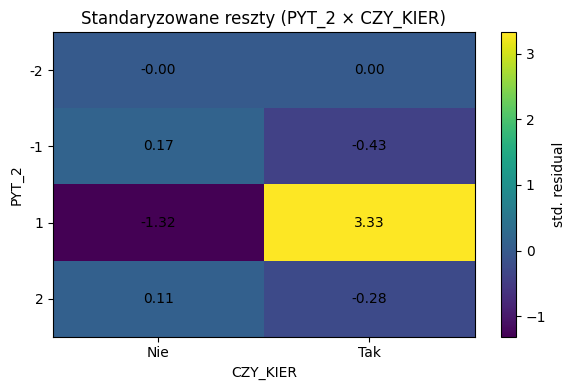

In [132]:
from scipy import stats    # Pojawiał się błąd, gdy bez tego

table = pd.crosstab(df["PYT_2"], df["CZY_KIER"])

chi2, p, dof, expected = stats.chi2_contingency(table, correction=False)

print(f"Chi2 = {chi2:.4f}, p-value = {p:.4f}, df = {dof}")
if p < 0.05:
    print("→ ODRZUCAMY H₀: zadowolenie zależy od stanowiska")
else:
    print("→ Brak podstaw do odrzucenia H₀: zadowolenie niezależne od stanowiska")

# Standaryzowane reszty
residuals = (table - expected) / np.sqrt(expected)

# Wykres asocjacyjny standaryzowanych reszt
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(residuals.values, aspect='auto')

ax.set_xticks(np.arange(len(table.columns)))
ax.set_yticks(np.arange(len(table.index)))
ax.set_xticklabels(table.columns)
ax.set_yticklabels(table.index)
ax.set_xlabel("CZY_KIER")
ax.set_ylabel("PYT_2")
ax.set_title("Standaryzowane reszty (PYT_2 × CZY_KIER)")

for i in range(residuals.shape[0]):
    for j in range(residuals.shape[1]):
        ax.text(j, i, f"{residuals.values[i,j]:.2f}", 
                ha="center", va="center")

fig.colorbar(im, ax=ax, orientation="vertical", label="std. residual")
plt.tight_layout()
plt.show()

Test chi-kwadrat daje $\chi^2(3) = 13{,}11$ z $p = 0{,}0044$, co przy $\alpha = 0{,}05$ pozwala odrzucić $H_0$ o niezależności – poziom zadowolenia (PYT\_2) istotnie różni się między kierownikami a pozostałymi pracownikami. Wynik ten jest zgodny z zadaniem 6.

Patrząc na standaryzowane reszty, największy wkład w tę zależność wnosi komórka „PYT\_2 = 1 (zgadzam się)” w kolumnie „Tak” (reszta $\approx +3{,}33$), co oznacza, że kierownicy znacząco częściej niż oczekiwano deklarują umiarkowaną zgodę na tezę o dopasowaniu szkoleń. Odwrotnie jest wśród nie-kierowników, którzy w tej samej kategorii wypadają poniżej oczekiwań (reszta $\approx -1{,}32$). Pozostałe komórki mają niewielkie reszty, więc główny efekt to przewaga kierowników deklarujących zgodę.


___
## Zadanie 9

In [133]:
def moc_testu(n, p, N=500, alpha=0.05):
    np.random.seed(0)
    count_fisher = 0
    count_chi2 = 0
    
    for _ in range(N):
        # Generujemy próbę zapewniając, że nie ma zerowych marginesów
        while True:
            x = np.random.multinomial(n, p)
            # marginesy wierszy i kolumn
            row_sums = [x[0]+x[1], x[2]+x[3]]
            col_sums = [x[0]+x[2], x[1]+x[3]]
            if all(s > 0 for s in row_sums + col_sums):
                break
        
        table = np.array([[x[0], x[1]], [x[2], x[3]]])
        
        _, p_fisher = stats.fisher_exact(table, alternative='two-sided')
        if p_fisher < alpha:
            count_fisher += 1
        
        _, p_chi2, _, _ = stats.chi2_contingency(table, correction=False)
        if p_chi2 < alpha:
            count_chi2 += 1
    
    return count_fisher / N, count_chi2 / N

In [134]:
p = [1/40, 3/40, 19/40, 17/40]
ns = [50, 100, 1000]
results = []

for n in ns:
    pow_f, pow_c = moc_testu(n, p, N=500, alpha=0.05)
    results.append((n, pow_f, pow_c))

df_results = pd.DataFrame(results, columns=['n', 'Power Fisher', 'Power Chi2'])
df_results

,n,Power Fisher,Power Chi2
0,50,0.124,0.198
1,100,0.306,0.384
2,1000,1.000,1.000


Przy bardzo małej próbie ($n = 50$) oba testy mają niską moc, ale test chi-kwadrat ($\approx 0{,}20$) jest nieco bardziej czuły niż dokładny test Fishera ($\approx 0{,}12$). Dla $n = 100$ różnice utrzymują się ($\approx 0{,}38$ vs. $\approx 0{,}31$), choć moc obu rośnie. Natomiast przy $n = 1000$ oba testy osiągają moc praktycznie równą $1$, co oznacza niemal pewność wykrycia tej wielkości efektu.

Generalnie więc: im większa próba, tym większa moc; test chi-kwadrat ma nieco wyższą moc od testu Fishera dla umiarkowanych $n$, ale przy dużych próbkach oba są równie skuteczne.


___
## Zadanie 10

In [135]:
def poziom_krytyczny_lr(table, alpha=0.05):
    """
    table : 2D array–like z nieujemnymi liczbami całkowitymi (kontyngencja R×C)
    alpha : poziom istotności (domyślnie 0.05)

    Zwraca:
      crit     – wartość graniczna G² , tzn. chi2.ppf(1-alpha, df=(R-1)*(C-1))
      G2_stat  – obliczoną statystykę G² = -2 log λ
      df_       – stopnie swobody = (R-1)*(C-1)
    """
    table = np.asarray(table, dtype=float)
    r, c = table.shape
    n = table.sum()
    row_sums = table.sum(axis=1)
    col_sums = table.sum(axis=0)

    # log ilorazu λ = ∑_{i,j} n_ij * [ log( (n_{i+} n_{+j}) / (n * n_ij) ) ]
    log_lambda = 0.0
    for i in range(r):
        for j in range(c):
            nij = table[i, j]
            if nij > 0:
                log_lambda += nij * (
                    np.log(row_sums[i] * col_sums[j])
                    - np.log(n * nij)
                )

    G2_stat = -2 * log_lambda
    df_ = (r - 1) * (c - 1)
    crit = stats.chi2.ppf(1 - alpha, df_)

    return crit, G2_stat, df_

In [136]:
tab = pd.crosstab(df["PYT_2"], df["CZY_KIER"])  # 4×2

crit, G2, df_ = poziom_krytyczny_lr(tab, alpha=0.05)
print(f"G² = {G2:.4f}, df = {df_}, krytyczne G²_crit = {crit:.4f}")

if G2 > crit:
    print("→ ODRZUCAMY H₀: zadowolenie zależy od stanowiska")
else:
    print("→ Brak podstaw do odrzucenia H₀: zadowolenie niezależne")

G² = 8.3285, df = 3, krytyczne G²_crit = 7.8147
→ ODRZUCAMY H₀: zadowolenie zależy od stanowiska


Statystyka ilorazu wiarygodności wyniosła $G^2 = 8{,}33$ ($df = 3$), a wartość krytyczna przy $\alpha = 0{,}05$ to $7{,}81$, więc $G^2 > G^2_{\text{crit}}$ i odrzucamy $H_0$. Oznacza to, że poziom zadowolenia ze szkoleń istotnie różni się między pracownikami na stanowiskach kierowniczych a pozostałymi, co potwierdza wniosek z wcześniejszego testu chi-kwadrat i testu Fishera.
